In [2]:
from typing import Text, Generator, Tuple, List, Optional, Dict, Set
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import json
import random
import re
import base64
import ast
import copy
import imgkit
import math
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from tabulate import tabulate
sns.set_theme()

config = imgkit.config(wkhtmltoimage='../wkhtmltopdf/bin/wkhtmltoimage.exe')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
pd.options.display.float_format = '{:.2f}'.format

# 1. Load Datasets

In [3]:
rico_path = "../data/rico/unique_uis/combined/"

def show_images(ranked, img_path, relevances=None):
    fig = plt.figure(figsize=(25,25)) # specifying the overall grid size
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(math.ceil(len(ranked)/3)),3),
                 axes_pad=0.3,  share_all=True
                 )
    if relevances is None:
        relevances = np.zeros(len(ranked))
    for ax, rank, relevance in zip(grid, ranked, relevances):
        rico_id = rank[0]
        img = Image.open(img_path + str(rico_id) + ".jpg")
        img = img.resize((1080, 1920))
        ax.imshow(np.array(img))
        ax.grid(False)
        title = str(rico_id) + ", " + str(round(rank[1], 2))
        if relevance != 0:
            title += ", " + relevance
        ax.title.set_text(title)

    plt.show()

In [7]:
df_sample_descriptions_test = pd.read_csv('../data/gui_descriptions/split/dataset_test_k_top_20_binary_one_to_ten_annotated.csv')
df_sample_descriptions_test = df_sample_descriptions_test.drop(columns=['binary_reasonings', 'one_to_ten_reasonings', 'binary_full_responses', 'binary_prompt_tokens', 'binary_completion_tokens', 'binary_total_prompt_tokens', 'binary_total_completion_tokens', 'one_to_ten_full_responses', 'one_to_ten_prompt_tokens', 'one_to_ten_completion_tokens', 'one_to_ten_total_prompt_tokens', 'one_to_ten_total_completion_tokens'])
df_sample_descriptions_test['rico_ranking'] = df_sample_descriptions_test['rico_ranking'].apply(ast.literal_eval)
df_sample_descriptions_test['binary_annotation'] = df_sample_descriptions_test['binary_annotation'].apply(ast.literal_eval)
df_sample_descriptions_test['one_to_ten_annotation'] = df_sample_descriptions_test['one_to_ten_annotation'].apply(ast.literal_eval)
df_sample_descriptions_test['num_relevant'] = df_sample_descriptions_test['binary_annotation'].apply(lambda x: np.sum(x))
df_sample_descriptions_test.rename(columns={'Descriptions': 'description'}, inplace=True)

In [9]:
df_sample_descriptions_test

,RICO GUI,description,Length,rico_ranking,binary_annotation,one_to_ten_annotation,num_relevant
0,28918,An app made for navigation.,27,"[51024, 40804, 65779, 46769, 28619, 39464, 46771, 15170, 30748, 27316, 42014, 15990, 48836, 68970, 61599, 43326, 48845, 60273, 7007, 18953]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]","[5, 4, 9, 9, 8, 9, 8, 9, 9, 7, 4, 8, 9, 6, 7, 7, 4, 8, 1, 9]",17
1,52757,A page from a recipe app allowing users to search for recipies in different categories,86,"[3671, 29116, 23384, 12361, 4792, 59931, 4793, 37173, 15251, 45738, 4781, 204, 70332, 10374, 38660, 25186, 45740, 10373, 6391, 38675]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]","[9, 7, 3, 4, 6, 6, 4, 10, 3, 7, 9, 3, 8, 8, 3, 9, 7, 7, 8, 4]",9
2,59109,A page from an App that is a fashion Q&A where others can help one another with different style choices.,104,"[59801, 34503, 31880, 5462, 51890, 53486, 31883, 66963, 40150, 55477, 42120, 15251, 48138, 58089, 21544, 54839, 35833, 4240, 13183, 60823]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1]",0
3,10428,"an organisational app GUI, allowing the user to list the grocerys and save recipes",82,"[70332, 20419, 52098, 42040, 38675, 25931, 50386, 10374, 29951, 6391, 21272, 29955, 59911, 25185, 30134, 12361, 70329, 25123, 53724, 38660]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]","[4, 2, 4, 2, 7, 4, 2, 5, 2, 4, 4, 2, 8, 5, 5, 3, 5, 1, 8, 8]",4
4,66742,"A alarm app GUI, that allows to download and play multiple audios to use as an alarm.",85,"[25320, 59744, 32234, 1877, 70626, 25307, 59743, 47248, 52571, 61176, 35927, 45210, 5678, 4399, 35925, 57548, 10127, 17903, 70077, 47244]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 2, 1, 4, 2, 7, 6, 3, 2, 3, 3, 4, 3, 3, 4, 4, 2, 8, 5, 5]",2
5,30144,"A page of an recipe finder, showing pictures of the food",56,"[15251, 12361, 17370, 3671, 10369, 29116, 25185, 19817, 23379, 38660, 59907, 56741, 72168, 70329, 59931, 45738, 37166, 6391, 8167, 23090]","[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]","[3, 2, 9, 9, 9, 8, 7, 6, 7, 3, 2, 3, 2, 9, 9, 9, 7, 9, 9, 7]",11
6,14854,A weather app GUI that shows the weather forecast for a given city in the following 7 days.,91,"[60117, 48751, 21589, 28347, 48742, 28346, 48737, 48756, 11618, 37964, 2894, 28767, 61561, 48740, 42609, 232, 29887, 25250, 8318, 21890]","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 9, 9, 8, 9, 3, 7, 4, 6, 3, 4, 3, 4, 4, 3, 2, 3, 3, 7, 4]",6
7,51979,"The schedule app shows the upcoming matches of a sportsteam. It states the enemy team, where and when the Game will be and shows the logo of each team.",151,"[5482, 20381, 51968, 48247, 68444, 5177, 42251, 44145, 42736, 20376, 56027, 5174, 19834, 361, 57895, 30505, 61612, 61592, 42725, 37033]","[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]","[9, 8, 5, 6, 9, 8, 1, 2, 9, 2, 1, 3, 0, 3, 4, 1, 1, 2, 8, 4]",7
8,11579,a page from a language learning app showing common phrases in Spanish and their translations.,93,"[27731, 45033, 27738, 27729, 52372, 29441, 60912, 27745, 27730, 35612, 63794, 29439, 60921, 52365, 27151, 12092, 60922, 42070, 27742, 59467]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 7, 7, 5, 0, 1, 2, 5, 7, 3, 2, 2, 2, 2, 2, 1, 2, 3, 7, 1]",1
9,69312,"The GUI from a recipe app, showing a picture and the step by step directions for the dish",89,"[37166, 62610, 62629, 15251, 25185, 59907, 62628, 21272, 30134, 59920, 10374, 38660, 72166, 12361, 8167, 45732, 52091, 37167, 5258, 35915]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]","[6, 4, 3, 3, 6, 2, 1, 3, 7, 4, 3, 2, 6, 2, 3, 7, 8, 5, 2, 4]",2


In [10]:
df_sample_descriptions_with_prompts = df_sample_descriptions_test.copy()

# 2. OpenAI

In [11]:
def extract_html(completion):
    html_content = re.search(r'<!DOCTYPE html>.*</html>', completion, re.DOTALL)
    if html_content:
        extracted_text = html_content.group()
        extracted_text = extracted_text.replace('```html','').replace('```','')
        return extracted_text
    else:
        html_content = re.search(r'<html>.*</html>', completion, re.DOTALL)
        if html_content:
            extracted_text = html_content.group()
            extracted_text = extracted_text.replace('```html','').replace('```','')
            return extracted_text
    return ''

def extract_html_cot(completion):
    html_content = re.search(r'<!-- Start -->.*<!-- End -->', completion, re.DOTALL)
    extracted_text = html_content.group()
    extracted_text = extracted_text.replace('```html','').replace('```','')
    return extracted_text

def write_html_to_file_and_image(path, model_name, dataset):
    for index, row in dataset.iterrows():
        file_name = str(index)
        with open(path+file_name+'.html', 'w', encoding='utf-8') as file:
            print(path+file_name+'.html')
            file.write(row[model_name])
        try:
            imgkit.from_string(row[model_name], path+file_name+'.jpg', config=config)
        except:
            pass

In [12]:
from openai import OpenAI
client = OpenAI()

In [13]:
def generate_completion(prompt, model='gpt-4o', temp=0.50, n=1, max_tokens=30000, logprobs=False, top_logprobs=5, return_obj=True, verbose=False, num_rows=-1):
    if verbose:
        if num_rows == -1:
            print('Generating completion...')
        else:
            print('[{}] - Generating completion...'.format(num_rows))
    if logprobs:
        chat_completion = client.chat.completions.create(
              model=model,
              messages=[
                    {"role": "user", "content": prompt},
                ],
              temperature=temp,
              n=n,
              logprobs=logprobs,
        )
    else:
        chat_completion = client.chat.completions.create(
              model=model,
              messages=[
                    {"role": "user", "content": prompt},
                ],
              temperature=temp,
              n=n,
        )
        if chat_completion.choices[0].finish_reason == 'length':
            print("Response cut off. Starting a second request... Length: {}".format(chat_completion.usage.completion_tokens))
            prompt += '\n -------- \nYour last response was cut off. Continue exactly where you left.'
            chat_completion_2 = client.chat.completions.create(
              model=model,
              messages=[
                    {"role": "user", "content": prompt},
                      {
                        "role": "assistant",
                        "content": chat_completion.choices[0].message.content
                    }
                ],
              temperature=temp,
              n=n,
        )
            chat_completion.choices[0].message.content += chat_completion_2.choices[0].message.content
            chat_completion.usage.completion_tokens += chat_completion_2.usage.completion_tokens
            chat_completion.usage.prompt_tokens += chat_completion_2.usage.prompt_tokens
            chat_completion.usage.total_tokens += chat_completion_2.usage.total_tokens
    return chat_completion if return_obj else [choice.message.content for choice in chat_completion.choices]

In [14]:
def save_results(dataframe, method_name, keep_cols, completion_col, path_csv, path_html, html_extractor=extract_html, is_json=False):
    df_copy = dataframe.copy()
    selected_cols = ['RICO GUI', 'description', 'Length', 'rico_ranking', 'binary_annotation', 'filtered_rico_ids', completion_col]
    selected_cols.extend(keep_cols)
    df_copy = df_copy[selected_cols]
    df_copy['method'] = method_name
    if is_json:
        df_copy['generated_html'] =  df_copy[completion_col].apply(lambda x: html_extractor(x['choices'][0]['message']['content']))
        df_copy['token_input'] = df_copy[completion_col].apply(lambda x: x['usage']['prompt_tokens'])
        df_copy['token_output'] = df_copy[completion_col].apply(lambda x: x['usage']['completion_tokens'])
    else:
        df_copy['generated_html'] =  df_copy[completion_col].apply(lambda x: html_extractor(x.choices[0].message.content))
        df_copy['token_input'] = df_copy[completion_col].apply(lambda x: x.usage.prompt_tokens)
        df_copy['token_output'] = df_copy[completion_col].apply(lambda x: x.usage.completion_tokens)
    df_copy.to_csv(path_csv + method_name + '.csv', index=False)
    write_html_to_file_and_image(path_html, 'generated_html', df_copy)

# 3. Prompting Approaches

## 3.1 Baselines

## 3.1.1 Zero-Shot Instruction Prompt

In [15]:
TEMPERATURE = 0.5

In [16]:
PLACEHOLDER_SUMMARY = '{summary}'

In [17]:
ZS_TEMPLATE = """Given a short description of a mobile page, implement the described page with HTML and CSS code: 
{summary}
Do not provide any explanations, directly output the HTML. Provide the HTML and CSS together, do not seperate them.
"""

In [872]:
df_sample_descriptions_with_prompts['zero_shot_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: ZS_TEMPLATE.replace(PLACEHOLDER_SUMMARY, row['description']), axis=1)
df_sample_descriptions_with_prompts['zero_shot_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['zero_shot_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True), axis=1)
save_results(df_sample_descriptions_with_prompts, 'zero_shot_instruction', ['zero_shot_prompt'], 'zero_shot_completion', '../data/generated/00_dataset_test/data/01_baselines/', '../data/generated/00_dataset_test/guis/01_baselines/zs_instruction/')

## 3.1.2 Zero-Shot Chain-of-Thought Prompt

In [18]:
PLACEHOLDER_SUMMARY = '{summary}'

In [19]:
ZS_COT_TEMPLATE = """Given a short description of a mobile page, implement the described page with HTML and CSS code: 
{summary}
At the end, provide the entire code of the page. Before the code starts, use the word "<!-- Start -->" and use "<!-- End -->" to mark the end of the code. Do not use these words at other locations in your text. Let's think step by step
"""

In [228]:
df_sample_descriptions_with_prompts['zero_shot_cot_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: ZS_COT_TEMPLATE.replace(PLACEHOLDER_SUMMARY, row['description']), axis=1)
df_sample_descriptions_with_prompts['zero_shot_cot_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['zero_shot_cot_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True), axis=1)
save_results(df_sample_descriptions_with_prompts, 'zero_shot_cot', ['zero_shot_cot_prompt'], 'zero_shot_cot_completion', '../data/generated/00_dataset_test/data/01_baselines/', '../data/generated/00_dataset_test/guis/01_baselines/zs_cot/', extract_html_cot)

## 3.2.1 Prompt Decomposition (Zero-Shot)

In [21]:
TEMPERATURE = 0.5

In [22]:
PLACEHOLDER_SUMMARY = '{summary}'
PLACEHOLDER_REQUIREMENTS = '{requirements}'
PLACEHOLDER_IMPLEMENTATION = '{implementation}'
PLACEHOLDER_STRUCTURE = '{structure}'
PD_TEMPLATE_ZS_SUMMARY2REQUIREMENTS = """Using the provided short description of a mobile page, please analyze the content and identify the specific features that are necessary for optimal functionality and user experience. Focus solely on visible functionalities: {summary}"""
PD_TEMPLATE_ZS_REQUIREMENTS2IMPLEMENTATION = "Describe the necessary UI elements and their design for implementing a mobile page with the following features. Use popular design frameworks. Do not provide code, only describe it using text: {requirements}"
PD_TEMPLATE_ZS_IMPLEMENTATION2STRUCTURE = "Given a List of UI Elements for a mobile page. Describe how the structure, layout and overall design of the page could look like. Use popular design frameworks. Do not provide code, only describe it using text: {implementation}"
PD_TEMPLATE_ZS_STRUCTURE2CODE = """
Given a structure of UI elements for a mobile page. Implement the described page with HTML and CSS code:
{structure}
Do not provide any explanations, directly output the HTML/CSS code. Provide the HTML and CSS together, do not seperate them.
"""

In [ ]:
# 1. Summary2requirements
df_sample_descriptions_with_prompts['pd_zs_summary2requirements_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: PD_TEMPLATE_ZS_SUMMARY2REQUIREMENTS.replace(PLACEHOLDER_SUMMARY, row['description']), axis=1)
df_sample_descriptions_with_prompts['pd_zs_summary2requirements_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['pd_zs_summary2requirements_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)
df_sample_descriptions_with_prompts['pd_zs_summary2requirements_completion_content'] = df_sample_descriptions_with_prompts.apply(lambda row: row['pd_zs_summary2requirements_completion'].choices[0].message.content, axis=1)

In [ ]:
# 2. Requirements2implementation
df_sample_descriptions_with_prompts['pd_zs_requirements2implementation_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: PD_TEMPLATE_ZS_REQUIREMENTS2IMPLEMENTATION.replace(PLACEHOLDER_REQUIREMENTS, row['pd_zs_summary2requirements_completion_content']), axis=1)
df_sample_descriptions_with_prompts['pd_zs_requirements2implementation_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['pd_zs_requirements2implementation_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)
df_sample_descriptions_with_prompts['pd_zs_requirements2implementation_completion_content'] = df_sample_descriptions_with_prompts.apply(lambda row: row['pd_zs_requirements2implementation_completion'].choices[0].message.content, axis=1)

In [ ]:
# 3. Implementation2Strucutre
df_sample_descriptions_with_prompts['pd_zs_implementation2structure_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: PD_TEMPLATE_ZS_IMPLEMENTATION2STRUCTURE.replace(PLACEHOLDER_IMPLEMENTATION, row['pd_zs_requirements2implementation_completion_content']), axis=1)
df_sample_descriptions_with_prompts['pd_zs_implementation2structure_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['pd_zs_implementation2structure_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)
df_sample_descriptions_with_prompts['pd_zs_implementation2structure_completion_content'] = df_sample_descriptions_with_prompts.apply(lambda row: row['pd_zs_implementation2structure_completion'].choices[0].message.content, axis=1)

In [ ]:
# 4. Strucutre2code
df_sample_descriptions_with_prompts['pd_zs_structure2code_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: PD_TEMPLATE_ZS_STRUCTURE2CODE.replace(PLACEHOLDER_STRUCTURE, row['pd_zs_implementation2structure_completion_content']), axis=1)
df_sample_descriptions_with_prompts['pd_zs_strucutre2code_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['pd_zs_structure2code_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)

In [ ]:
save_results(df_sample_descriptions_with_prompts, 'pd_zs', ['pd_zs_summary2requirements_prompt', 'pd_zs_requirements2implementation_prompt', 'pd_zs_implementation2structure_prompt', 'pd_zs_structure2code_prompt', 'pd_zs_summary2requirements_completion', 'pd_zs_requirements2implementation_completion', 'pd_zs_implementation2structure_completion'], 'pd_zs_strucutre2code_completion', '../data/generated/00_dataset_test/data/02_prompt_decomposition/', '../data/generated/00_dataset_test/guis/02_prompt_decomposition/pd_zs/')

## 3.2.2 Chain-of-Thought (Explicit Structure - Engineered CoT) (Zero-Shot)

In [132]:
TEMPERATURE = 0.5

In [292]:
PLACEHOLDER_SUMMARY = "{summary}"

In [135]:
COT_EXPL_ZS_TEMPLATE = """
Based on a short description, create a mobile page, by completing the following steps:

1. Using the provided short description of a mobile page, please analyze the content and identify the specific features that are necessary for optimal functionality and user experience. Focus solely on visible functionalities.
2. Describe the necessary UI elements and their design for implementing a mobile page for the features identified in the first step. Use popular design frameworks. Do not provide code, only describe it using text.
3. Given a List of UI Elements for a mobile page. Describe how the structure, layout and overall design of the page could look like. Use popular design frameworks. Do not provide code, only describe it using text.
4. Given a structure of UI elements for a mobile page developed in the previous step. Implement the described page with HTML and CSS code. 

{summary}
At the end, provide the entire code of the page. Before the code starts, use the word "<!-- Start -->" and use "<!-- End -->" to mark the end of the code. Do not use these words at other locations in your text.
"""

In [ ]:
df_sample_descriptions_with_prompts['cot_expl_zs_prompt'] = df_sample_descriptions_with_prompts.apply(lambda row: COT_EXPL_ZS_TEMPLATE.replace(PLACEHOLDER_SUMMARY, row['description']), axis=1)
df_sample_descriptions_with_prompts['cot_expl_zs_completion'] = df_sample_descriptions_with_prompts.apply(lambda row: generate_completion(row['cot_expl_zs_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)
save_results(df_sample_descriptions_with_prompts, 'pd_zs_cot', ['cot_expl_zs_prompt'], 'cot_expl_zs_completion', '../data/generated/00_dataset_test/data/02_prompt_decomposition/', '../data/generated/00_dataset_test/guis/02_prompt_decomposition/pd_zs_cot/', extract_html_cot)

# 4. Retrieval-Augmentation GUI Generation

## 4.0 Helper Functions

In [23]:
data_path = "../data/"
rico_path = "../data/rico/unique_uis/combined/"

In [272]:
from mpl_toolkits.axes_grid1 import ImageGrid
import math

def show_images(ranked, img_path, relevances=None):
    fig = plt.figure(figsize=(15,15)) # specifying the overall grid size
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(math.ceil(len(ranked)/3)),3),
                 axes_pad=0.3,  share_all=True
                 )
    if relevances is None:
        relevances = np.zeros(len(ranked))
    for ax, rank, relevance in zip(grid, ranked, relevances):
        rico_id = rank[0]
        img = Image.open(img_path + str(rico_id) + ".jpg")
        img = img.resize((1080, 1920))
        ax.imshow(np.array(img))
        ax.grid(False)
        title = str(rico_id) + ", " + str(round(rank[1], 2))
        if relevance != 0:
            title += ", " + relevance
        ax.title.set_text(title)

    plt.show()

In [ ]:
import base64
import requests

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def respond_to_image(prompt, image, model="gpt-4o", temp=0.5, n=1, max_tokens=30000, return_obj=True, verbose=False, num_rows=-1):
    if verbose:
        if num_rows == -1:
            print('Generating completion...')
        else:
            print('[{}] - Generating completion...'.format(num_rows))
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        "model": model,
        "messages": [
            {"role": "user", "content": 
                [
                    {"type": "text", "text": prompt},
                        {
                            "type": "image_url",
                            "image_url": {
                            "url":  f"data:image/jpeg;base64,{image}",
                            },
                        },
                ]
            },
        ],
        "temperature": temp,
        "n": n,
    }
    chat_completion = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()    
    return chat_completion

## 4.1 Feature Summarization from GUIs (Vision)

In [285]:
METHOD_FILTERING_GUIS_BINARY = 'filtering_guis_binary'
METHOD_FILTERING_GUIS_REL_SCALE = 'filterin_guis_rel_scale'
METHOD_FILTERING_GUIS_BINARY_SORTED_REL_SCALE = 'filtering_guis_binary_sorted_rel_scale'

def compute_filtered_rico_ids(dataframe, method=METHOD_FILTERING_GUIS_BINARY, rel_scale_min=7):
    if method == METHOD_FILTERING_GUIS_BINARY:
        dataframe['filtered_rico_ids'] = dataframe.apply(lambda row: [rico_id for rico_id, annotation in zip(row['rico_ranking'], row['binary_annotation']) if annotation==1], axis=1)
    elif method == METHOD_FILTERING_GUIS_REL_SCALE:
        dataframe['filtered_rico_ids'] = dataframe.apply(lambda row: [rank for rank, anno in zip(row['rico_ranking'], row['relevance_scale']) if anno >= rel_scale_min], axis=1)
    elif method == METHOD_FILTERING_GUIS_BINARY_SORTED_REL_SCALE:
        dataframe['filtered_rico_ids'] = dataframe.apply(lambda row: [(rico_id, rel_scale) for rico_id, annotation, rel_scale in zip(row['rico_ranking'], row['binary_annotation'], row['relevance_scale']) if annotation==1], axis=1)
        dataframe['filtered_rico_ids'] = dataframe['filtered_rico_ids'].apply(lambda x: sorted(x, key=lambda y: y[1], reverse=True))
        dataframe['filtered_rico_ids'] = dataframe['filtered_rico_ids'].apply(lambda x: [rico_id for (rico_id, rel_scale) in x])

### 4.1.1 Extract GUI Feature List

In [286]:
df_sample_descriptions_rag = df_sample_descriptions_test.copy()

In [287]:
df_sample_descriptions_rag = df_sample_descriptions_rag.rename(columns={'one_to_ten_annotation':'relevance_scale'})

In [288]:
df_sample_descriptions_rag[:2]

,RICO GUI,description,Length,rico_ranking,binary_annotation,relevance_scale,num_relevant
0,28918,An app made for navigation.,27,"[51024, 40804, 65779, 46769, 28619, 39464, 46771, 15170, 30748, 27316, 42014, 15990, 48836, 68970, 61599, 43326, 48845, 60273, 7007, 18953]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]","[5, 4, 9, 9, 8, 9, 8, 9, 9, 7, 4, 8, 9, 6, 7, 7, 4, 8, 1, 9]",17
1,52757,A page from a recipe app allowing users to search for recipies in different categories,86,"[3671, 29116, 23384, 12361, 4792, 59931, 4793, 37173, 15251, 45738, 4781, 204, 70332, 10374, 38660, 25186, 45740, 10373, 6391, 38675]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]","[9, 7, 3, 4, 6, 6, 4, 10, 3, 7, 9, 3, 8, 8, 3, 9, 7, 7, 8, 4]",9


In [289]:
compute_filtered_rico_ids(df_sample_descriptions_rag, method=METHOD_FILTERING_GUIS_BINARY_SORTED_REL_SCALE)

In [290]:
df_sample_descriptions_rag[:2]

,RICO GUI,description,Length,rico_ranking,binary_annotation,relevance_scale,num_relevant,filtered_rico_ids
0,28918,An app made for navigation.,27,"[51024, 40804, 65779, 46769, 28619, 39464, 46771, 15170, 30748, 27316, 42014, 15990, 48836, 68970, 61599, 43326, 48845, 60273, 7007, 18953]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]","[5, 4, 9, 9, 8, 9, 8, 9, 9, 7, 4, 8, 9, 6, 7, 7, 4, 8, 1, 9]",17,"[65779, 46769, 39464, 15170, 30748, 48836, 18953, 28619, 46771, 15990, 60273, 27316, 61599, 43326, 68970, 42014, 48845]"
1,52757,A page from a recipe app allowing users to search for recipies in different categories,86,"[3671, 29116, 23384, 12361, 4792, 59931, 4793, 37173, 15251, 45738, 4781, 204, 70332, 10374, 38660, 25186, 45740, 10373, 6391, 38675]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]","[9, 7, 3, 4, 6, 6, 4, 10, 3, 7, 9, 3, 8, 8, 3, 9, 7, 7, 8, 4]",9,"[37173, 3671, 4781, 25186, 70332, 10374, 6391, 29116, 10373]"


In [291]:
df_sample_descriptions_rag[:2][['description', 'filtered_rico_ids']]

,description,filtered_rico_ids
0,An app made for navigation.,"[65779, 46769, 39464, 15170, 30748, 48836, 18953, 28619, 46771, 15990, 60273, 27316, 61599, 43326, 68970, 42014, 48845]"
1,A page from a recipe app allowing users to search for recipies in different categories,"[37173, 3671, 4781, 25186, 70332, 10374, 6391, 29116, 10373]"


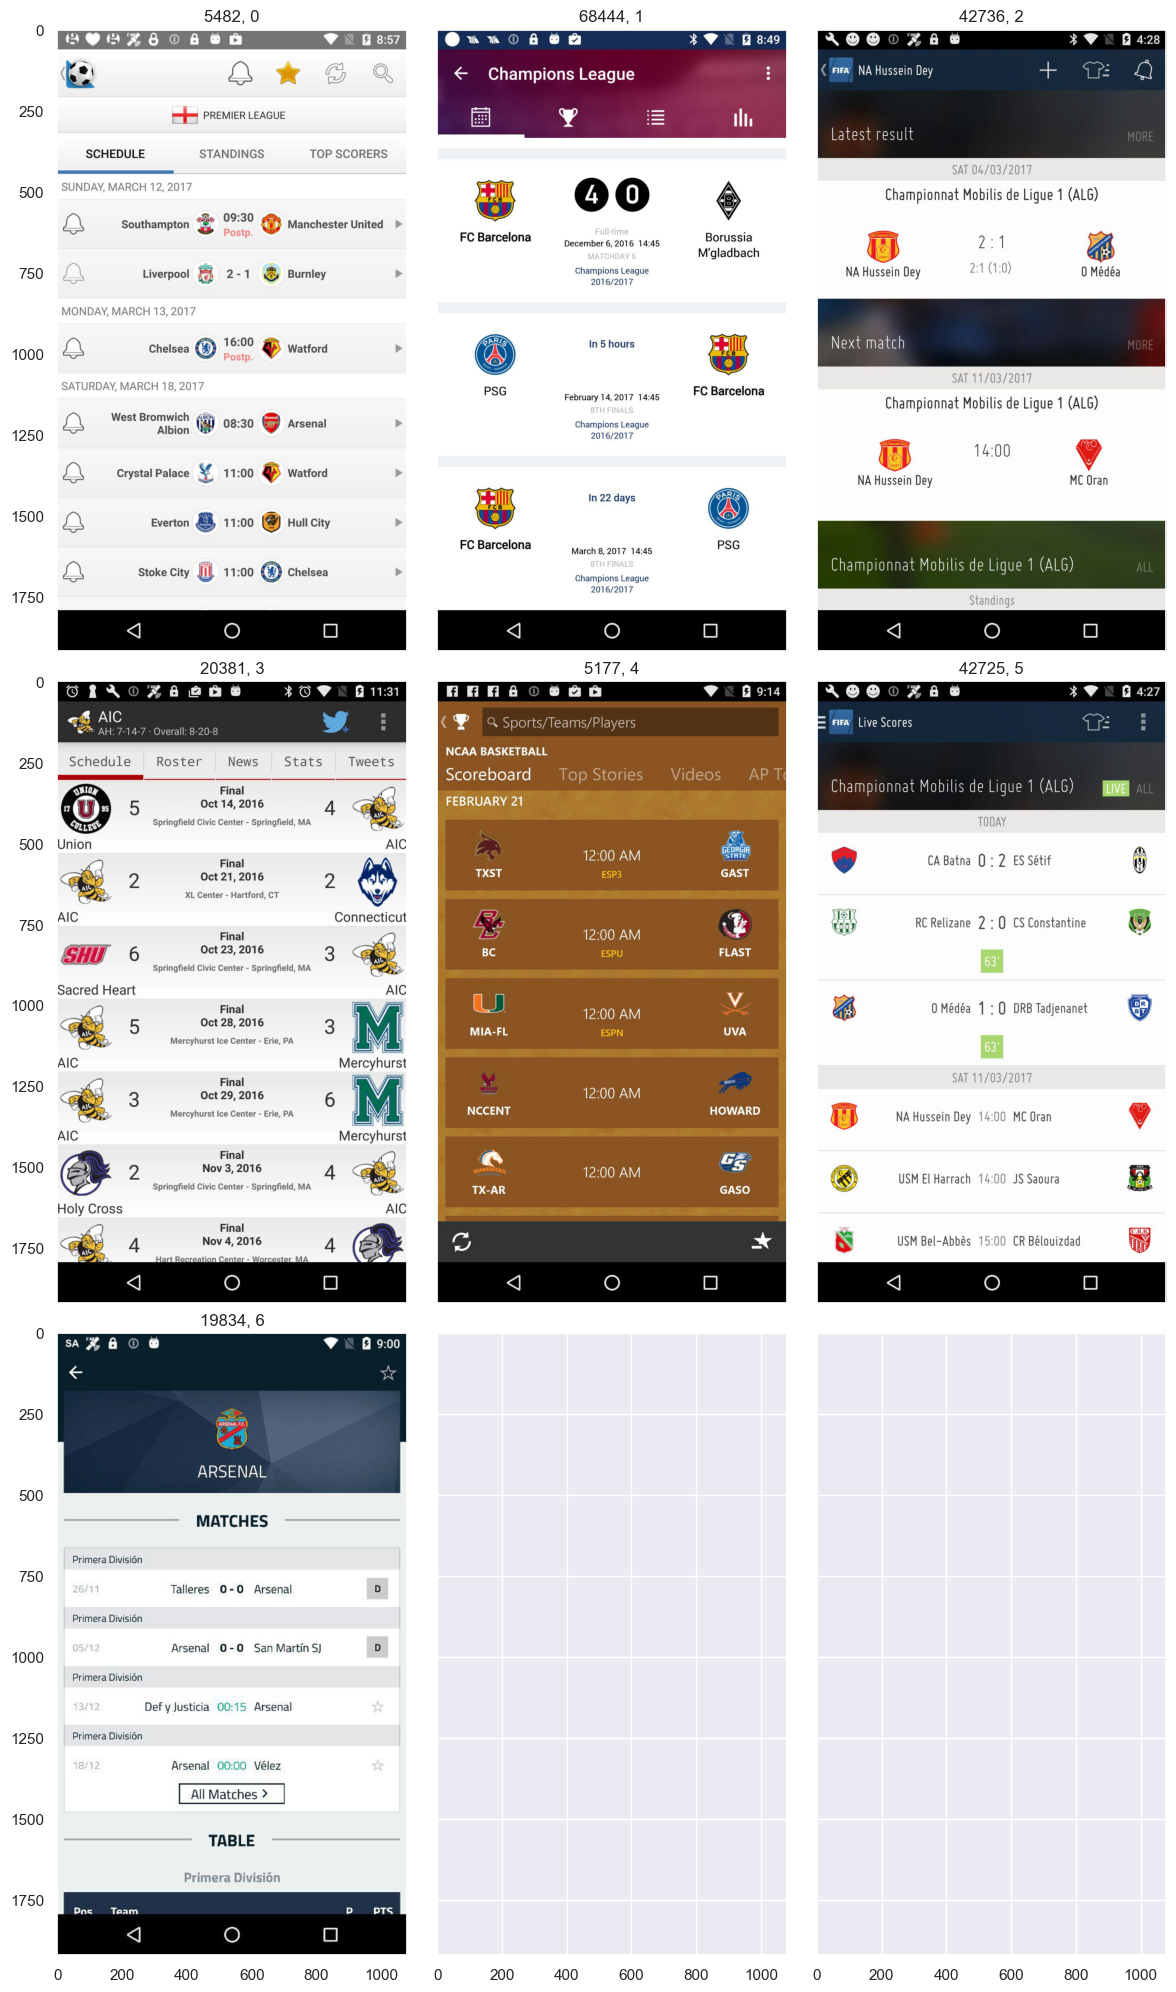

In [292]:
show_images([(elem, idx) for idx, elem in enumerate(df_sample_descriptions_rag['filtered_rico_ids'].values.tolist()[7])], rico_path)

In [154]:
TEMPERATURE = 0.5
TOP_K = 3

In [155]:
GUI_FEATURE_EXTRACTION_TEMPLATE_ZS_IMAGE = '''You are given a user interface of a mobile app. Please extract a high-level list of user interface features present in the user interface and provide a short description of each feature. Ignore the top status bar (e.g., battery level, signal strength etc.).'''

In [ ]:
df_sample_descriptions_rag['gui_feature_extraction_zs_image_completion'] = df_sample_descriptions_rag.apply(lambda row: [respond_to_image(GUI_FEATURE_EXTRACTION_TEMPLATE_ZS_IMAGE, encode_image(rico_path + str(rico_id) + ".jpg"), model='gpt-4o', temp=TEMPERATURE, verbose=True, num_rows=row.name) for rico_id in row['filtered_rico_ids'][:TOP_K]], axis=1)
df_sample_descriptions_rag['gui_feature_extraction_zs_image_completion_extracted'] = df_sample_descriptions_rag.apply(lambda row: [elem["choices"][0]["message"]["content"] for elem in row['gui_feature_extraction_zs_image_completion']], axis=1)

### 4.1.2 Aggregate GUI Feature List

In [162]:
PLACEHOLDER_FEATURE_LISTS = '{feature_lists}'

In [163]:
GUI_FEATURE_AGGREGATION_ZS_PROMPT = '''You are given a list of features of a user interface of a mobile app from up to ''' + str(TOP_K) + ''' apps, that have similar functionality. Please aggregate the user interface features from the different feature lists into a single list. Therefore, create a ranking of user interface features starting with the features that are most common among the lists ending with the least common ones. Also indicate in brackets () after each feature the count how often it occurred. For each feature, always include a short description.\n\n{feature_lists}'''

In [165]:
def create_feature_list_str(feature_lists):
    final_feature_list = ''
    for count, elem in enumerate(feature_lists,1):
        final_feature_list+='Feature list {}:\n'.format(str(count))
        final_feature_list+=elem + '\n\n'
    return final_feature_list

In [166]:
df_sample_descriptions_rag['gui_feature_aggregation_zs_image_prompt'] = df_sample_descriptions_rag.apply(lambda row: GUI_FEATURE_AGGREGATION_ZS_PROMPT.replace(PLACEHOLDER_FEATURE_LISTS, create_feature_list_str(row['gui_feature_extraction_zs_image_completion_extracted'])), axis=1)
df_sample_descriptions_rag['gui_feature_aggregation_zs_image_completion'] = df_sample_descriptions_rag.apply(lambda row: generate_completion(row['gui_feature_aggregation_zs_image_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)
df_sample_descriptions_rag['gui_feature_aggregation_zs_image_completion_content'] = df_sample_descriptions_rag['gui_feature_aggregation_zs_image_completion'].apply(lambda x: x.choices[0].message.content)

## 4.2 Layout Summerization from GUIs (Vision)

### 4.2.1 Extract GUI Layouts

In [172]:
TEMPERATURE = 0.5
TOP_K = 3

In [173]:
GUI_LAYOUT_EXTRACTION_TEMPLATE_ZS_IMAGE = '''Given this user interface of a mobile app, please briefly summarize the overall layout and design by identifying the main layouting groups and providing their abstract functionality, do not provide detailed feature explanations, rather more abstract layouting and positing descriptions. Do not consider the status bar (e.g., battery level, signal strength etc.)'''

In [ ]:
df_sample_descriptions_rag['gui_layout_extraction_zs_image_completion'] = df_sample_descriptions_rag.apply(lambda row: [respond_to_image(GUI_LAYOUT_EXTRACTION_TEMPLATE_ZS_IMAGE, encode_image(rico_path + str(rico_id) + ".jpg"), model='gpt-4o', temp=TEMPERATURE, verbose=True, num_rows=row.name) for rico_id in row['filtered_rico_ids'][:TOP_K]], axis=1)
df_sample_descriptions_rag['gui_layout_extraction_zs_image_completion_content'] = df_sample_descriptions_rag.apply(lambda row: [elem["choices"][0]["message"]["content"] for elem in row['gui_layout_extraction_zs_image_completion']], axis=1)

### 4.2.2 Aggregate GUI Layouts

In [186]:
PLACEHOLDER_LAYOUT_LISTS = '{layout_lists}'

In [187]:
GUI_LAYOUT_AGGREGATION_ZS_PROMPT = '''You are given a summary of the general layout of a user interface of a mobile app from up to ''' + str(TOP_K) + ''' apps, that have similar functionality. Please aggregate the user interface layout and design descriptions from the different layout lists into a single, aggregated and consistent list.\n\n{layout_lists}'''

In [189]:
def create_layout_list_str(feature_lists):
    final_feature_list = ''
    for count, elem in enumerate(feature_lists,1):
        final_feature_list+='Layout {}:\n'.format(str(count))
        final_feature_list+=elem + '\n\n'
    return final_feature_list

In [190]:
df_sample_descriptions_rag['gui_layout_aggregation_zs_image_prompt'] = df_sample_descriptions_rag.apply(lambda row: GUI_LAYOUT_AGGREGATION_ZS_PROMPT.replace(PLACEHOLDER_LAYOUT_LISTS, create_layout_list_str(row['gui_layout_extraction_zs_image_completion_content'])), axis=1)
df_sample_descriptions_rag['gui_layout_aggregation_zs_image_completion'] = df_sample_descriptions_rag.apply(lambda row: generate_completion(row['gui_layout_aggregation_zs_image_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)
df_sample_descriptions_rag['gui_layout_aggregation_zs_image_completion_content'] = df_sample_descriptions_rag.apply(lambda row: row['gui_layout_aggregation_zs_image_completion'].choices[0].message.content, axis=1)

### 4.3 Prompting (Zero-Shot Feature+Layout Augmentation) (Vision)

In [195]:
PLACEHOLDER_SUMMARY = '{summary}'
PLACEHOLDER_RETRIEVED_FEATURES = '{retrieved_features}'
PLACEHOLDER_RETRIEVED_LAYOUTS = '{retrieved_layouts}'

In [196]:
ZS_FEATURE_AND_LAYOUT_AUGMENTATION_TEMPLATE = """Given a short description of a mobile page, a list of features and typical layouts extracted from relevant GUIs for the short description, implement the described page with HTML and CSS code. Do not provide any explanations or descriptions, directly output the code. Provide the HTML and CSS together, do not seperate them. 
Description: {summary}
Features: 
{retrieved_features}
Layouts: 
{retrieved_layouts}
"""

In [197]:
df_sample_descriptions_rag['zero_shot_image_feature_and_layout_augmentation_prompt'] = df_sample_descriptions_rag.apply(lambda row: ZS_FEATURE_AND_LAYOUT_AUGMENTATION_TEMPLATE.replace(PLACEHOLDER_SUMMARY, row['description']).replace(PLACEHOLDER_RETRIEVED_FEATURES, row['gui_feature_aggregation_zs_image_completion_content']).replace(PLACEHOLDER_RETRIEVED_LAYOUTS, row['gui_layout_aggregation_zs_image_completion_content']), axis=1)
df_sample_descriptions_rag['zero_shot_image_feature_and_layout_augmentation_completion'] = df_sample_descriptions_rag.apply(lambda row: generate_completion(row['zero_shot_image_feature_and_layout_augmentation_prompt'], model='gpt-4o', temp=TEMPERATURE, logprobs=False, return_obj=True, verbose=True, num_rows=row.name), axis=1)

In [ ]:
save_results(df_sample_descriptions_rag, 'rag_zs_k_3_feat_layout', ['gui_feature_extraction_zs_image_completion', 'gui_feature_aggregation_zs_image_completion', 'gui_layout_extraction_zs_image_completion', 'gui_layout_aggregation_zs_image_completion'], 'zero_shot_image_feature_and_layout_augmentation_completion', '../data/generated/00_dataset_test/data/03_rag/', '../data/generated/00_dataset_test/guis/03_rag/rag_zs_k_3_feat_layout/')

## 4.4 Direct Encoding of Top-k GUIs

### 4.4.1 OpenAI

In [264]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def respond_to_image_multiple(prompts_and_images, model="gpt-4o", temp=0.5, n=1, max_tokens=30000, return_obj=True, timeout=300):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    messages = []
    for prompt, image in prompts_and_images:
        if image is not None:
            message = {"role": "user", "content": 
                        [
                            {"type": "text", "text": prompt},
                                {
                                    "type": "image_url",
                                    "image_url": {
                                    "url":  f"data:image/jpeg;base64,{image}",
                                },
                                }
                        ]
                      }
        else:
            message = {"role": "user", "content": 
                        [{"type": "text", "text": prompt}]
                      }
        messages.append(message)
    payload = {
        "model": model,
        "messages": messages,
        "temperature": temp,
        "n": n,
    }
    chat_completion = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload, timeout=timeout).json()    
    return chat_completion

### 4.4.2 Directly Generate HTML/CSS with RAGG

In [279]:
max_number = len(df_sample_descriptions_rag)

In [280]:
for i in range(0,10):
    curr_size = len(df_sample_descriptions_rag[df_sample_descriptions_rag['num_relevant']>=i])
    ratio_affected = curr_size / max_number
    print('[{}]: #Left: {} | Ratio: {}'.format(i, curr_size, ratio_affected))

[0]: #Left: 50 | Ratio: 1.0
[1]: #Left: 37 | Ratio: 0.74
[2]: #Left: 33 | Ratio: 0.66
[3]: #Left: 28 | Ratio: 0.56
[4]: #Left: 26 | Ratio: 0.52
[5]: #Left: 24 | Ratio: 0.48
[6]: #Left: 21 | Ratio: 0.42
[7]: #Left: 15 | Ratio: 0.3
[8]: #Left: 11 | Ratio: 0.22
[9]: #Left: 11 | Ratio: 0.22


In [308]:
TOP_K = 7

In [261]:
PLACEHOLDER_SUMMARY = '{placeholder_summary}'
PLACEHOLDER_IMPLEMENTATION = '{placeholder_implementation}'

In [282]:
RAG_ZS_DIRECT_PROMPT_1 = '''You are given a description for a GUI of a mobile page. In addition, you are given several screenshots of 
relevant GUIs for the description. These were found in a large GUI database using the description to search. Sometimes there also
might be no relevant GUI at all. Given the description and the screenshots of relevant GUIs, your task is to implement a mobile page
in HTML and CSS for the description. You can use the GUI screenshots as inspirations for features, design and layout. You need to use
all the feature from the relevant GUIs in you final answer. Do not provide any explanation, directly output the HTML/CSS. 
Provide the HTML and CSS together, do not seperate them:
Description: {placeholder_summary}
'''

In [283]:
def encode_images_with_prompt_and_call_completion(prompt, description, image_ids, temp=0.5):
    print('#Images: {} | Desc: {}'.format(len(image_ids), description))
    descs = []
    for counter, rico_id in enumerate(image_ids, 1):
        image = encode_image(rico_path + str(rico_id) + ".jpg")
        descs.append(("GUI : " + str(counter), image))
    prompts = [(prompt, None)]
    prompts.extend(descs)
    full_response = respond_to_image_multiple(prompts, temp=temp)
    return full_response

In [ ]:
print('TOP_K: {}'.format(TOP_K))
df_sample_descriptions_rag['rag_zs_k_7_encoded_images_direct_completion'] = df_sample_descriptions_rag.apply(lambda row: encode_images_with_prompt_and_call_completion(RAG_ZS_DIRECT_PROMPT_1.replace(PLACEHOLDER_SUMMARY, row['description']), row['description'], row['filtered_rico_ids'][:TOP_K]), axis=1)

In [ ]:
save_results(df_sample_descriptions_rag, 'rag_zs_k_7_direct', [], 'rag_zs_k_7_encoded_images_direct_completion', '../data/generated/00_dataset_test/data/03_rag/', '../data/generated/00_dataset_test/guis/03_rag/rag_zs_k_7_direct/', is_json=True)